In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from pathlib import Path
import sys
sys.path.append('../../code/')
sys.path.append('/Users/ssulheim/git/mwf_gems/code/python')
import leakage_reframed
import ng_utils
import leakage
import reframed
import scipy

# Ecoli

In [2]:
exometabolites_folder = Path("../../data/e_coli/")
organism = 'e_coli'
fn_OD = exometabolites_folder / "{0}_OD.csv".format(organism)

In [3]:
gDW_per_OD = 0.32

In [4]:
concentrations, concentrations_std = leakage.get_concentrations(exometabolites_folder, 'e_coli')

In [6]:
concentrations['FUM']

Time
0       NaN
1     13.50
2      1.25
3      1.25
4      0.00
5      1.00
6      2.00
7      2.50
8      5.00
9      3.00
10     3.00
11     3.50
12     2.00
13     0.00
14     0.00
15     0.00
16     0.00
17     0.00
26     0.00
Name: FUM, dtype: float64

## Remove outliers

In [5]:
concentrations.loc[1, 'FUM'] = np.nan

In [6]:
df_OD = pd.read_csv(fn_OD, index_col=0)
df_OD.fillna(df_OD['OD std'].mean())

,OD mean,OD std
Time,,
0,0.500,0.116168
1,0.514,0.116168
2,0.608,0.116168
3,0.817,0.116168
4,1.595,0.049497
5,2.295,0.190919
6,5.085,0.035355
7,8.765,0.106066
8,13.300,0.056569


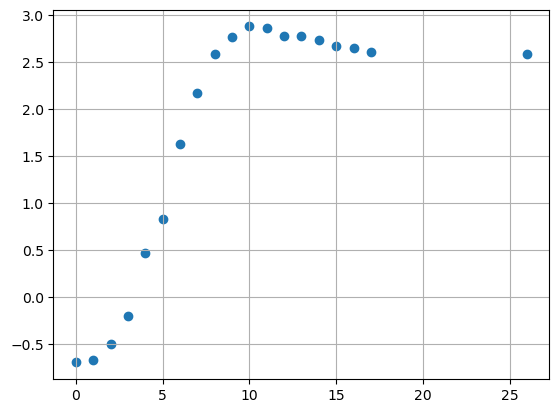

In [7]:
plt.scatter(df_OD.index, np.log(df_OD['OD mean']))
plt.grid()

## Mapping

In [8]:
mapping_df = pd.read_csv('../../data/id_mapping.csv', index_col=0)
# mapping_df.index = [x.strip('\t').replace(" MS", "") for x in mapping_df.index]
met_abrv_to_id = mapping_df['Ecoli metabolite'].to_dict()
met_abrv_to_name = mapping_df['Metabolite name'].to_dict()


# Estimate rates

In [57]:
xt = np.zeros(len(df_OD)-1)
for i in range(1, len(df_OD)-1):
    
    xt[i] = np.trapz(df_OD.loc[:i, 'OD mean'], dx=1)
    print(i, df_OD.loc[i, 'OD mean'], xt[i]*gDW_per_OD)

1 0.514 0.16224
2 0.608 0.34176
3 0.817 0.56976
4 1.595 0.95568
5 2.295 1.57808
6 5.085 2.75888
7 8.765 4.97488
8 13.3 8.50528
9 15.94 13.183679999999999
10 17.78 18.578879999999998
11 17.45 24.215680000000003
12 16.1 29.583680000000005
13 15.99 34.71808000000001
14 15.34 39.730880000000006
15 14.43 44.494080000000004
16 14.21 49.07648
17 13.61 53.52767999999999


In [65]:
x = pd.Series(xt*gDW_per_OD, index = df_OD.index[:-1])
print(x)

Time
0      0.00000
1      0.16224
2      0.34176
3      0.56976
4      0.95568
5      1.57808
6      2.75888
7      4.97488
8      8.50528
9     13.18368
10    18.57888
11    24.21568
12    29.58368
13    34.71808
14    39.73088
15    44.49408
16    49.07648
17    53.52768
dtype: float64


In [64]:
x = np.cumsum(df_OD['OD mean'])*gDW_per_OD
print(x)

Time
0      0.16000
1      0.32448
2      0.51904
3      0.78048
4      1.29088
5      2.02528
6      3.65248
7      6.45728
8     10.71328
9     15.81408
10    21.50368
11    27.08768
12    32.23968
13    37.35648
14    42.26528
15    46.88288
16    51.43008
17    55.78528
26    60.01248
Name: OD mean, dtype: float64


In [18]:
# TODO implement this
specific_limits = {
    'OAS':5,
    'TYR':7,
    'PRO':6,
}

/Users/ssulheim/anaconda3/lib/python3.11/site-packages/scipy/optimize/_minpack_py.py:906: OptimizeWarning: Covariance of the parameters could not be estimated
  warnings.warn('Covariance of the parameters could not be estimated',


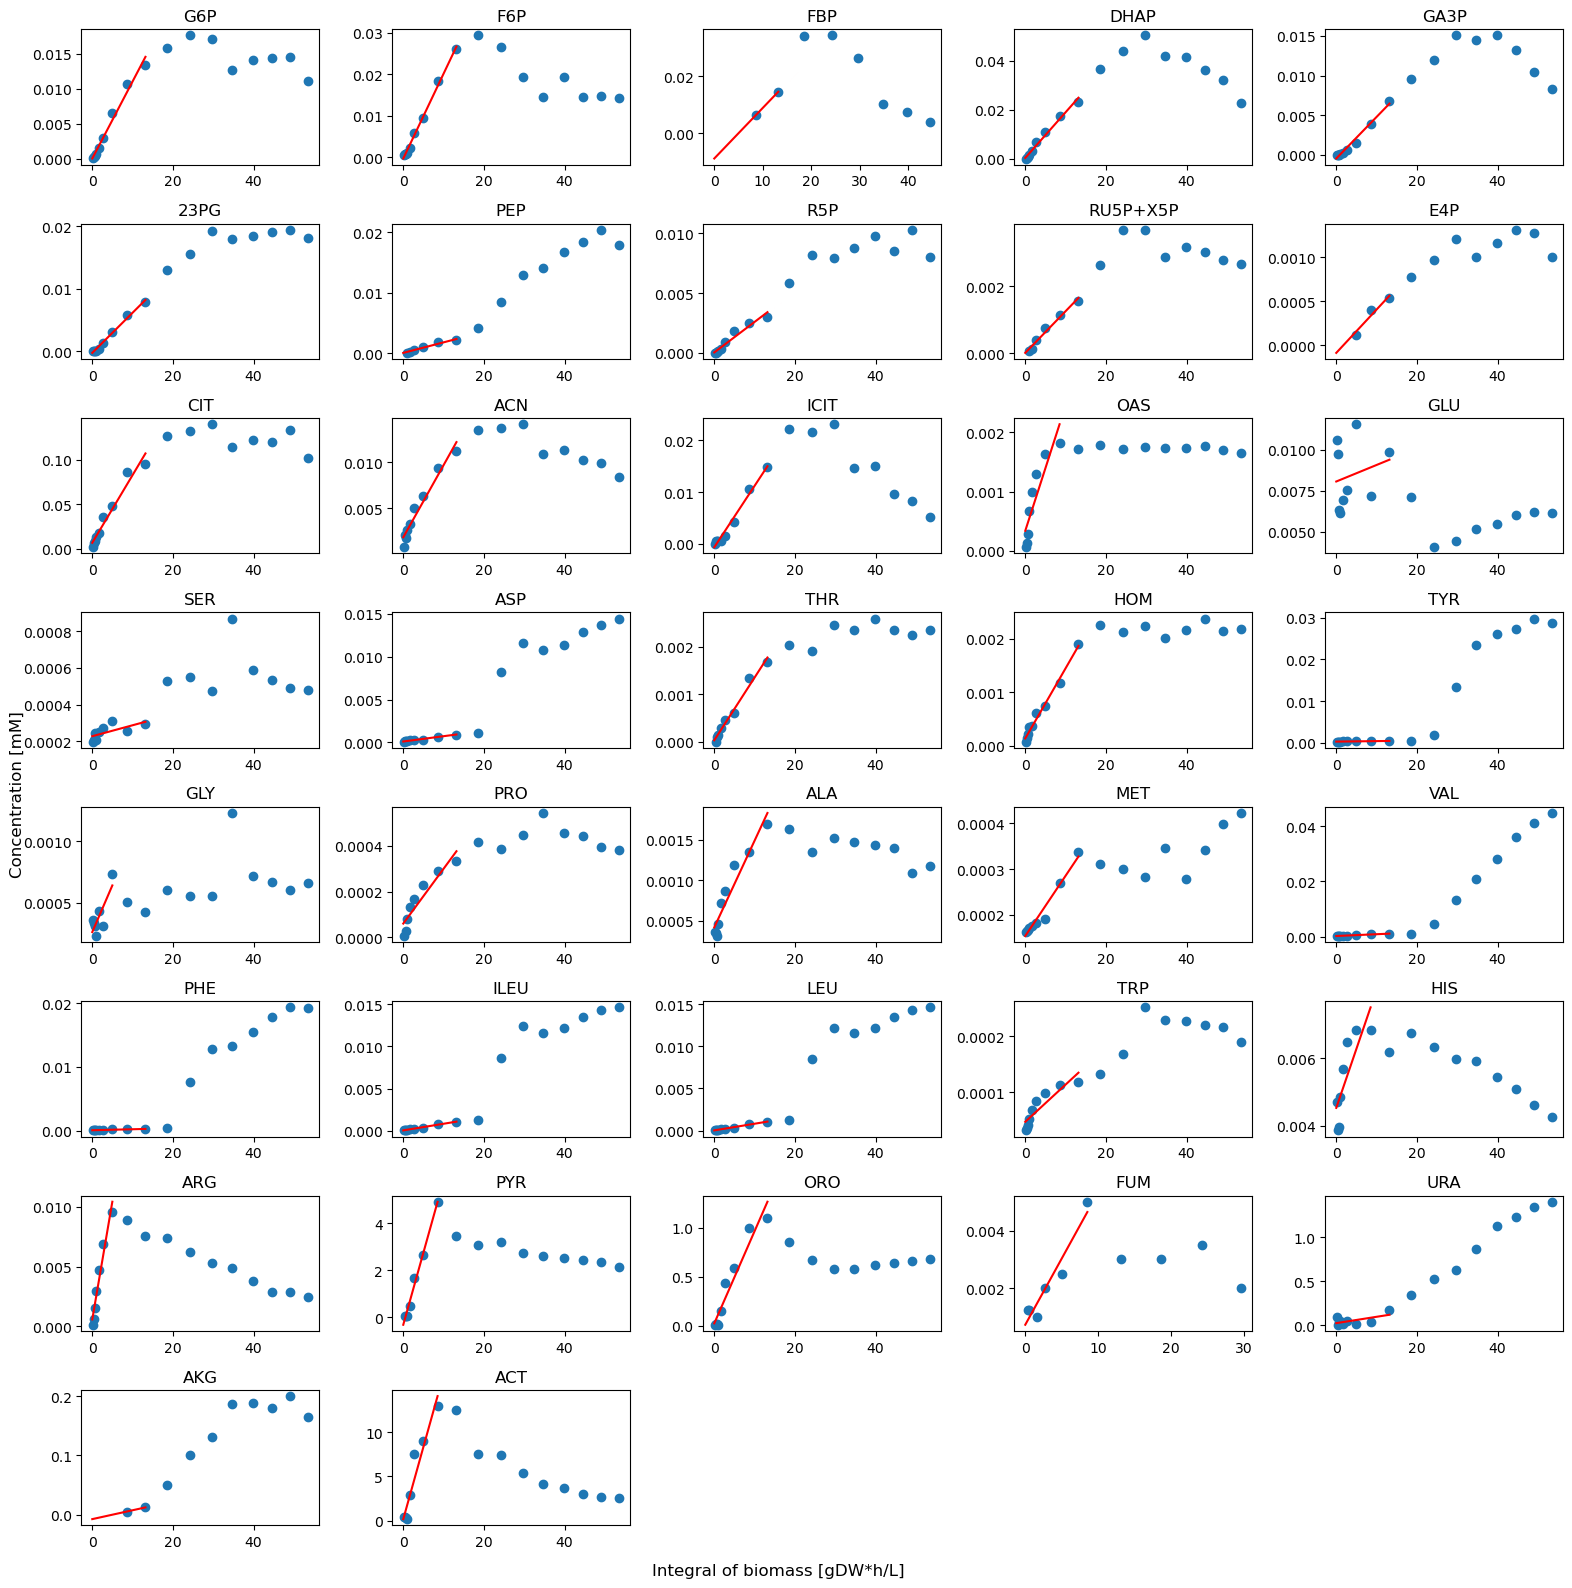

In [68]:
rate_dict = {}
fig, axes = plt.subplots(8,5, figsize = (16, 16), sharex = False)
axes = axes.flatten()
fun = lambda x, a ,b: x*a+b
for i,c in enumerate(concentrations.columns):
    conc = concentrations[c][:-1]*1e-3
    conc[conc==0] = np.nan
    nan_idx = ~np.isnan(conc)
    time_idx = x.index < 10
    if np.sum(nan_idx&time_idx) == 1:
        conc[0] = 0
        nan_idx[0] = True
        
    # print(conc[nan_idx&time_idx])
    rate_conc = conc[nan_idx&time_idx]
    selection = np.ones(len(conc)).astype(bool)
    if (7 in rate_conc.index) and (8 in rate_conc.index) and (9 in rate_conc.index):
        if rate_conc[9] < rate_conc[8]:
            selection[9] = False
            if rate_conc[8] < rate_conc[7]:
                selection[8] = False
                if rate_conc[7] < rate_conc[6]:
                    selection[7] = False
    # print(selection, rate_conc, rate_conc.index)
    # print(c)
    # print(conc[nan_idx&time_idx])
    fit, cov, _,_,_ = scipy.optimize.curve_fit(fun, x[nan_idx&time_idx&selection],
                                               conc[nan_idx&time_idx&selection], full_output=True)
    rate_dict[c] = fit[0]

    # print(fit)
    x_fit = np.linspace(0, x[nan_idx&time_idx&selection].max(), 3)
    y_fit = fun(x_fit, *fit)
    ax = axes[i]
    # ax.scatter(x, conc)
    ax.scatter(x, conc)
    ax.plot(x_fit, y_fit, 'r')
    ax.set_title(c, )

i +=1
# print(i)
while i<(8*5):
    axes[i].set_visible(False)
    i+=1

fig.supxlabel('Integral of biomass [gDW*h/L]')
fig.supylabel('Concentration [mM]')

plt.tight_layout()
plt.savefig('ecoli_fitted_rates.png', dpi = 400)
plt.show()


In [69]:
rate_dict

{'G6P': 0.0011060629014694413,
 'F6P': 0.0020438630961777124,
 'FBP': 0.0017669858641843374,
 'DHAP': 0.001862578526493631,
 'GA3P': 0.00052383351490945,
 '23PG': 0.000643448456387922,
 'PEP': 0.00017454212947284528,
 'R5P': 0.00025541121637583835,
 'RU5P+X5P': 0.00012459524382429837,
 'E4P': 4.920935639092868e-05,
 'CIT': 0.007605199008696812,
 'ACN': 0.0007856560214868905,
 'ICIT': 0.0011876212826904143,
 'OAS': 0.00021158000856976255,
 'GLU': 0.00010092423510135329,
 'SER': 5.960916723873026e-06,
 'ASP': 6.190854166162204e-05,
 'THR': 0.00013172775964581004,
 'HOM': 0.00013109594813140124,
 'TYR': 1.184718869252e-05,
 'GLY': 7.624632233833985e-05,
 'PRO': 2.3883043815659988e-05,
 'ALA': 0.00010672687977443106,
 'MET': 1.3173628971115737e-05,
 'VAL': 6.493584888859917e-05,
 'PHE': 1.5580837317569538e-05,
 'ILEU': 7.86515993960125e-05,
 'LEU': 7.906595931180378e-05,
 'TRP': 6.662759529985253e-06,
 'HIS': 0.0003515130475695271,
 'ARG': 0.001979527609206667,
 'PYR': 0.6168376812817167,


In [53]:
rate_dict

{'G6P': 0.0010438761283126908,
 'F6P': 0.001720037214288813,
 'FBP': 0.000596339084436308,
 'DHAP': 0.0017176988667935021,
 'GA3P': 0.00036506899822389257,
 '23PG': 0.0005704583195396499,
 'PEP': 0.0001870830349953417,
 'R5P': 0.0002577601755898069,
 'RU5P+X5P': 0.00011597389234638379,
 'E4P': 6.557017551691731e-05,
 'CIT': 0.007723297310963466,
 'ACN': 0.0007720359996694818,
 'ICIT': 0.0009509267679088724,
 'OAS': 0.00016911827635094167,
 'GLU': -0.0006224406079930662,
 'SER': 2.0556739443967277e-05,
 'ASP': 4.9480288006758606e-05,
 'THR': 0.00012063788397414984,
 'HOM': 9.86093578992601e-05,
 'TYR': 6.984309404403658e-06,
 'GLY': 8.878831055930616e-07,
 'PRO': 2.5795461110732794e-05,
 'ALA': 0.0001046368516559598,
 'MET': 9.124717030733685e-06,
 'VAL': 5.130530390372902e-05,
 'PHE': 1.6431976758965484e-05,
 'ILEU': 6.459028052273799e-05,
 'LEU': 6.298291340417741e-05,
 'TRP': 7.73214549522216e-06,
 'HIS': 0.0002819625922307103,
 'ARG': 0.0020602710165909767,
 'PYR': 0.491033397706315

# Get model

In [54]:
model_ez = reframed.load_cbmodel('../../models/e_coli/momentiJO1366.xml')
model_ez.solver = 'gurobi'

In [55]:
reframed.FBA(model_ez)

Objective: 0.7429753865197839
Status: Optimal

In [56]:
measured_metabolites = []
for bigg_id in met_abrv_to_id.values():
    if not isinstance(bigg_id, str):
        continue
    m_ids = bigg_id.split(', ')
    for m_id in m_ids:
        if f'M_{m_id}_c' in model_ez.metabolites:
            measured_metabolites.append(f'M_{m_id}_c')

# Shadow prices

In [57]:
shadow_prices = leakage_reframed.estimate_shadow_prices(model_ez, constraints={'R_EX_glc__D_e': (-8,0)}, metabolites = measured_metabolites)

# Turnover

In [58]:
solution = reframed.pFBA(model_ez, constraints={'R_EX_glc__D_e': (-8,0)})
turnover = solution.get_metabolites_turnover(model_ez)

    

# Make spreadsheet

In [59]:
data = []
for abbr, rate in rate_dict.items():
    bigg_ids = [x.strip() for x in met_abrv_to_id[abbr].split(',')]
    rate = rate/len(bigg_ids)
    for bigg_id in bigg_ids:
        name =met_abrv_to_name[abbr]
        m_id = f'M_{bigg_id}_c'
        mv = -shadow_prices[m_id]
        m = model_ez.metabolites[m_id]
        element_dict = ng_utils.get_element_dict(m)
        Nc = element_dict['C']
        mass = ng_utils.get_mol_weight(m)
        
        data.append([bigg_id, name, rate, mv, turnover[m_id], Nc, mass])
df_rate = pd.DataFrame(data, columns = ['BiGG ID', 'Metabolite', 'Rate [mmol/gDW/h]', 
                                        'Metabolite value [gDW/mmol]', 'Turnover [mmol/gDW/h]', 'N carbons', 
                                        'Mol weight [g/mol]'])

In [60]:
df_rate['Species'] = 'E. coli'
df_rate['Carbon source'] = 'Glucose'
df_rate['Dataset'] = 'Paczia-13'

In [62]:
df_rate.to_csv('paczia_13_rates_ecoli.csv')